In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# Data Importing and DF setup

In [36]:
df = pd.read_csv('../data/kaggle_historical_df.csv')

In [44]:
df

,High,Low,Open,Close,Volume,Marketcap
date,,,,,,
2021-02-27,48253.270101,45269.025766,46344.772237,46188.451275,4.591095e+10,8.609781e+11
2021-02-26,48370.785260,44454.842114,47180.464054,46339.760083,3.509679e+11,8.637523e+11
2021-02-25,51948.966982,47093.853019,49709.082425,47093.853019,5.450657e+10,8.777661e+11
2021-02-24,51290.136695,47213.498162,48835.087661,49705.333316,6.369552e+10,9.263931e+11
2021-02-23,54204.929756,45290.590268,54204.929756,48824.426869,1.061025e+11,9.099259e+11
...,...,...,...,...,...,...
2013-05-03,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
2013-05-02,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
2013-05-01,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09


In [38]:
df.dtypes

timestamp     object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Marketcap    float64
dtype: object

In [39]:
df = df.rename(columns={"timestamp": "date"})
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df = df.set_index('date')
df.head()

,High,Low,Open,Close,Volume,Marketcap
date,,,,,,
2021-02-27,48253.270101,45269.025766,46344.772237,46188.451275,4.591095e+10,8.609781e+11
2021-02-26,48370.785260,44454.842114,47180.464054,46339.760083,3.509679e+11,8.637523e+11
2021-02-25,51948.966982,47093.853019,49709.082425,47093.853019,5.450657e+10,8.777661e+11
2021-02-24,51290.136695,47213.498162,48835.087661,49705.333316,6.369552e+10,9.263931e+11
2021-02-23,54204.929756,45290.590268,54204.929756,48824.426869,1.061025e+11,9.099259e+11


<AxesSubplot:xlabel='date'>

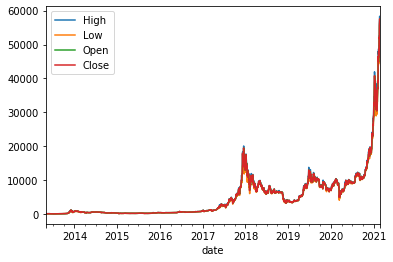

In [55]:
df[['High','Low','Open','Close']].plot()

# ARIMA exploration

In [43]:
y = df['Close']
y.shape

(2862,)

In [42]:
from statsmodels.tsa.stattools import adfuller
print('p-value: ', adfuller(y)[1])

p-value:  2.5264145709226113e-08


In [45]:
# First diff
print('p-value: ', adfuller(y.diff(1).fillna(0))[1])

p-value:  2.0357146227314016e-23


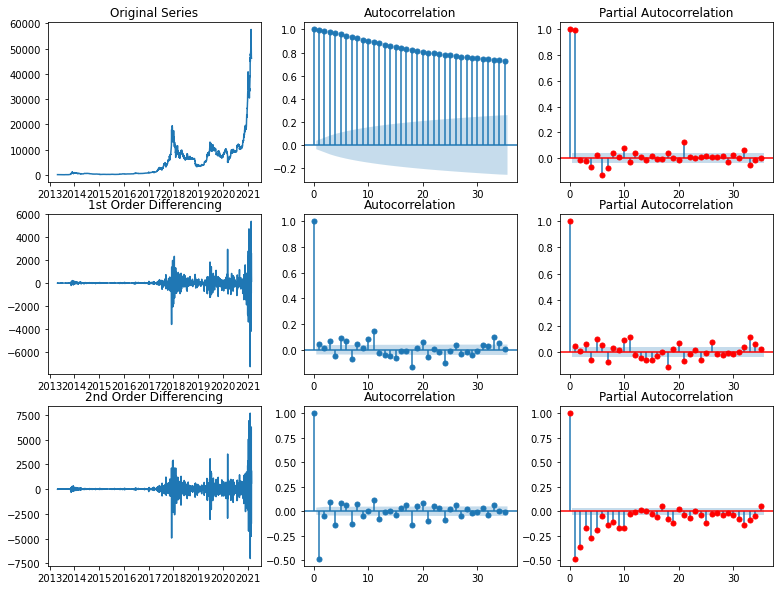

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original Series
fig, axes = plt.subplots(3, 3, figsize=(13,10))
axes[0, 0].plot(y); axes[0, 0].set_title('Original Series')
plot_acf(y, ax=axes[0, 1])
plot_pacf(y, ax=axes[0, 2],c='r')

# 1st Differencing
axes[1, 0].plot(y.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y.diff().dropna(), ax=axes[1, 1])
plot_pacf(y.diff().dropna(), ax=axes[1, 2],c='r')

# 2nd Differencing
axes[2, 0].plot(y.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y.diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(y.diff().diff().dropna(), ax=axes[2, 2],c='r')

plt.show()

In [56]:
from statsmodels.tsa.arima_model import ARIMA

# 1. initialize the model
arima = ARIMA(y, order=(1, 1, 1))

# 2. fit the models
arima = arima.fit()

arima.summary()

/home/diego/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  warnings.warn('No frequency information was'
/home/diego/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/diego/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  warnings.warn('No frequency information was'
/home/diego/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2861
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -21260.233
Method:                       css-mle   S.D. of innovations            408.343
Date:                Wed, 03 Mar 2021   AIC                          42528.465
Time:                        13:09:58   BIC                          42552.301
Sample:                             1   HQIC                         42537.060
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -15.7360      9.707     -1.621      0.105     -34.761       3.289
ar.L1.D.Close     0.8569      0.049     17.530      0.000       0.761       0.953
ma.L1.D.Close    -0.8180      0.054    -15.165      0.000      -0.924      -0.712
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1669           +0.0000j            1.1669            0.0000
MA.1            1.2225           +0.0000j            1.2225            0.0000
-----------------------------------------------------------------------------
"""

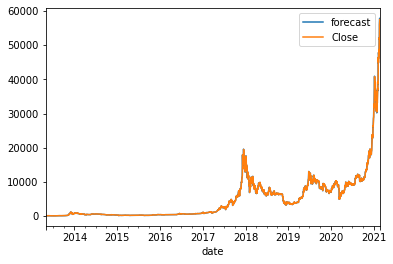

In [57]:
# Actual vs Fitted
arima.plot_predict(dynamic=False);

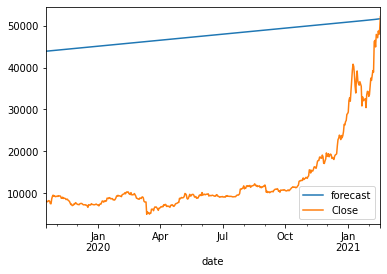

In [74]:
arima.plot_predict(10, 500, dynamic=True);

# Prophet 

In [82]:
df_pro = pd.read_csv('../data/kaggle_historical_df.csv')

In [83]:
df_pro = df_pro.drop(columns = ['High','Low','Open','Volume','Marketcap'])

In [86]:
df_pro.head()

,ds,y
0,2021-02-27,46188.451275
1,2021-02-26,46339.760083
2,2021-02-25,47093.853019
3,2021-02-24,49705.333316
4,2021-02-23,48824.426869


In [90]:
df_pro.columns = ['ds', 'y']
df_pro['ds'] = pd.to_datetime(df_pro['ds'])
df_pro.dtypes

ds    datetime64[ns]
y            float64
dtype: object

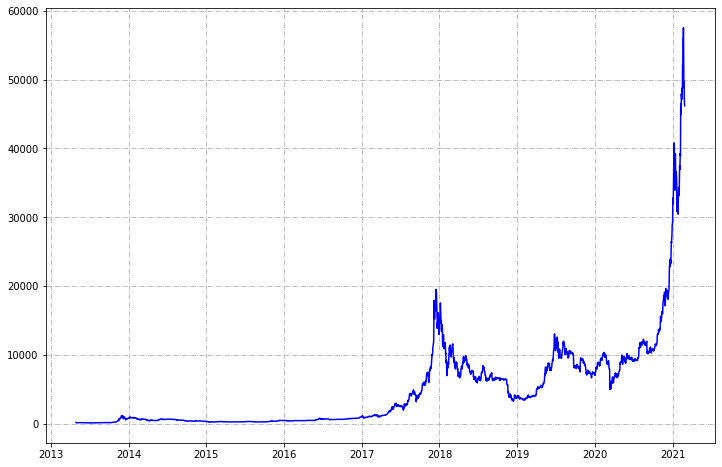

In [91]:
plt.figure(figsize=(12, 8))
plt.grid(linestyle='-.')

plt.plot(df_pro['ds'], df_pro['y'], 'b')
plt.show()

In [92]:
#Fit the data using Facebook's Prophet library. Make sure to use a train/test split.
from fbprophet import Prophet
train = df.iloc[:176]
test = df.iloc[176:]

ModuleNotFoundError: No module named 'fbprophet'